# Project : Amazon Fine Food Reviews.

In [0]:
# import the libarys

import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import re
import string
import os
import pickle

from sklearn.feature_extraction.text import TfidfTransformer , TfidfVectorizer , CountVectorizer
from sklearn.metrics import confusion_matrix , roc_curve
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from cycler import cycler
from sklearn.model_selection import GridSearchCV
from sklearn import svm

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec , KeyedVectors

from tqdm import tqdm

from bs4 import BeautifulSoup

from prettytable import PrettyTable

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'19VumHcTH6JaUWpUTA58SecT_Z8RJIxrk'})
downloaded.GetContentFile('database.sqlite')

### Read the file

In [0]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

dataset_sqlite = pd.read_sql_query("""
                                    SELECT * FROM Reviews where Score != 3
                                    """ , con)

In [128]:
dataset_sqlite.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [129]:
np.unique(dataset_sqlite['Score'])

array([1, 2, 4, 5])

In [0]:
amnt_1 = dataset_sqlite.Score.value_counts()[1]
amnt_2 = dataset_sqlite.Score.value_counts()[2]
amnt_4 = dataset_sqlite.Score.value_counts()[4]
amnt_5 = dataset_sqlite.Score.value_counts()[5]

In [0]:
# Convert the Reviews value into positive and negetive

def partition(x):
    if x < 3:
        return 'negetive'
    
    return 'positive'

In [0]:
actual_score = dataset_sqlite['Score']
positiveNegetive = actual_score.map(partition)
dataset_sqlite['Score'] = positiveNegetive

In [133]:
dataset_sqlite.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negetive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negetive,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,positive,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,positive,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,positive,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [134]:
dataset_sqlite.shape

(525814, 10)

In [135]:
dataset_sqlite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null object
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


In [136]:
dataset_sqlite.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [0]:
amnt_pos = dataset_sqlite.Score.value_counts()['positive']
amnt_neg = dataset_sqlite.Score.value_counts()['negetive']

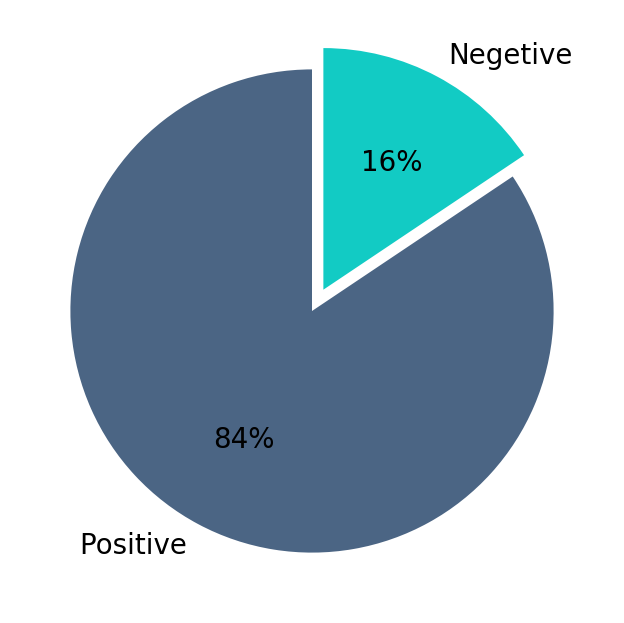

In [138]:
category_names = ['Positive' , 'Negetive']
sizes = [amnt_pos , amnt_neg]
custom_colours = ['#4b6584', '#12CBC4']

plt.figure(figsize = (10,8) , dpi=100)
plt.pie(sizes, labels=category_names , textprops={'fontsize': 20} , startangle = 90 , 
       autopct='%1.0f%%' , colors=custom_colours , explode=[0 , 0.1])

plt.show()

## Data Cleaning

In [139]:
display = pd.read_sql_query("""

                            select * from Reviews ORDER BY UserId
                            
                            """ , con)

display.head(15)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,136323,B006Q820X0,#oc-R103C0QSV1DF5E,C,1,2,5,1343088000,Great for the Price,I have to say I was a little apprehensive to b...
1,516062,B008I1XPKA,#oc-R109MU5OBBZ59U,AayGee,0,1,5,1350086400,AWESOME Coffee!!!!,Received my free K cups as a sample promotion ...
2,516079,B008I1XPKA,#oc-R10LFEMQEW6QGZ,Julie,0,1,5,1345939200,Brooklyn Bean Roastery Breakfast Blend K-Cups,Brooklyn Bean Roastery Blend K-Cups are great ...
3,378693,B0026LJ3EA,#oc-R10LT57ZGIB140,dipr,0,0,3,1310601600,Some damage,The shipment of the dog food was quick. Howev...
4,136545,B006Q820X0,#oc-R10UA029WVWIUI,Kim D,0,0,1,1342483200,Less than satisfactory. I gave the Brooklyn K...,"Brooklyn ""French Roast"" K-Cup Coffee is not on..."
5,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
6,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
7,21719,B005DVVB9K,#oc-R119LM8D59ZW8Y,"Lee Mellott ""SEOmenu2go""",5,11,1,1320192000,Not So Sweet Treat!,I love chocolate so I was excited to see the C...
8,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
9,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


There have been many duplicates rows in the dataset.In the above table 8,9,10 rows have similar customer and he buy different product and review it at the same time.So it can be a garbage value.There can be some miscalculation when save it into the database.So it is necessasry to remove those rows for better performance.

In [140]:
display = pd.read_sql_query("""

                            select * from Reviews where Score !=3 and UserId="#oc-R11D9D7SHXIJB9" ORDER BY ProductID
                            
                            """ , con)

display.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


Check how many product the perticular customer but at a same time.


Check some other Users

In [141]:
display= pd.read_sql_query("""

                        select *
                        from Reviews
                        where Score != 3 AND UserId = "AR5J8UI46CURR"
                        ORDER BY ProductID
                        
                        """, con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


It is shown that this customer also have buy many different product at the same time and review it.This can be happen when a specific product have different color or differnet flavor.
So remove the duplicate all rows.

In [142]:
# Sorting the dataset according to productID

sorted_data = dataset_sqlite.sort_values(
                        'ProductId' , axis = 0 , ascending = True , inplace = False , kind = 'quicksort' ,  na_position='last'
                        )
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


Find the duplicates if the useid , profilename , time , text is the same then it is duplicate.And remove those rows.

In [23]:
#Deduplication of entries

final = sorted_data.drop_duplicates(subset = {'UserId' , 'ProfileName' , 'Time' , 'Text'} , keep = 'first' , inplace = False)
final.shape

(364173, 10)

In [143]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0) / (dataset_sqlite['Id'].size*1.0) * 100

28.527197830411517

After removing those duplicates rows we hvae 69% data remaining.

Another way to fina inconsistency in the dataset is if the <b>HelpfulnessNumerator</b> is greater than <b>HelpfulnessDenominator</b>

In [144]:
display= pd.read_sql_query("""

                        SELECT *
                        FROM Reviews
                        WHERE HelpfulnessNumerator > HelpfulnessDenominator
                        
                        """, con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [145]:
display= pd.read_sql_query("""

                        SELECT *
                        FROM Reviews
                        WHERE Score != 3 AND Id=44737 OR Id=64422
                        ORDER BY ProductID
                        
                        """, con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [147]:
final.shape

(150000, 11)

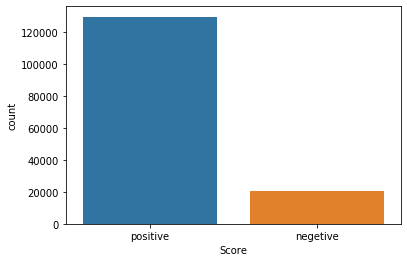

In [148]:
sns.countplot(x = 'Score' , data = final)

## Text Preprocessing

We already remove the duplicates values from the dataset.Now it's time to preprocess the dataset.There are many ways to clean or preprocess the dataset.


In [149]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english') 

In [0]:
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

In [0]:
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [153]:
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''

for sent in tqdm(final['Text'].values):

    filtered_sentence=[]

    sent=cleanhtml(sent) 

    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():

            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):    
                if(cleaned_words.lower() not in stop):
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s)
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue 
                
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|██████████| 150000/150000 [02:52<00:00, 871.78it/s]


In [154]:
final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode("utf-8")
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


In [0]:
final_data = final.sort_values('Time', axis=0 , ascending=True , inplace=False , kind='quicksort' , na_position = 'last')

In [156]:
final_data.shape

(150000, 11)

In [157]:
final = final_data.head(150000)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [0]:
x = final.drop(['Score'] , axis = 1)
y = final['Score']

In [0]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.25)

In [160]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(112500, 10)
(37500, 10)
(112500,)


In [0]:
x_train_data = final[:100000]
x_test_data = final[100000:150000]
y_train = x_train_data['Score']
y_test = x_test_data['Score']

In [162]:
print("Data")
print(x_train_data.shape)
print(x_test_data.shape)
print("Label")
print(y_train.shape)
print(y_test.shape)

Data
(100000, 11)
(50000, 11)
Label
(100000,)
(50000,)


In [221]:
#BoW on Text
print("**Bow Vectorizer**")
print("="*50)
count_vect = CountVectorizer(min_df = 50)
X_train_BOW = count_vect.fit_transform(x_train_data['CleanedText'])
X_test_BOW = count_vect.transform(x_test_data['CleanedText'])
print(X_train_BOW.shape)
print(X_test_BOW.shape)




print("**Bow Vectorizer-1**")
print("="*50)
count_vect1 = CountVectorizer(min_df = 50) #since it is very costly for rbf kernel so reducing the dimention
X_train_BOW1 = count_vect1.fit_transform(x_train_data['CleanedText'])
X_test_BOW1 = count_vect1.transform(x_test_data['CleanedText'])
print(X_train_BOW1.shape)
print(X_test_BOW1.shape)

**Bow Vectorizer**
(100000, 3846)
(50000, 3846)
**Bow Vectorizer-1**
(100000, 3846)
(50000, 3846)


In [164]:
#TFIDF on Text
print("**TFIDF Vectorizer**")
print("="*50) 
tf_idf_vect = TfidfVectorizer(min_df = 50)
X_train_tfidf = tf_idf_vect.fit_transform(x_train_data['CleanedText'])
X_test_tfidf = tf_idf_vect.transform(x_test_data['CleanedText'])
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

**TFIDF Vectorizer**
(100000, 3846)
(50000, 3846)


In [165]:
# Word2Vec in training part

import gensim
i=0
list_of_sent_train=[]
for sent in tqdm(x_train_data['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

100%|██████████| 100000/100000 [00:19<00:00, 5193.60it/s]


In [166]:
# word2vec in testing part

import gensim
i=0
list_of_sent_test=[]
for sent in tqdm(x_test_data['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

100%|██████████| 50000/50000 [00:10<00:00, 4630.05it/s]


In [167]:
print(x_train_data['Text'].values[0])
print("*****************************************************************")
print(list_of_sent_train[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is'

In [0]:
w2v_model = gensim.models.Word2Vec(list_of_sent_train , min_count = 5 , size = 50)

In [169]:
w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))

19044


In [170]:
w2v_model.wv.most_similar('good')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('great', 0.8260831236839294),
 ('decent', 0.8195675611495972),
 ('terrific', 0.7372971773147583),
 ('fantastic', 0.733842134475708),
 ('yummy', 0.7324783205986023),
 ('fine', 0.7224534749984741),
 ('bad', 0.7097476720809937),
 ('tasty', 0.6908984780311584),
 ('nice', 0.6904658675193787),
 ('awesome', 0.680310070514679)]

In [171]:
# average Word2Vec in trainin

sent_vectors_train = []; 

for sent in tqdm(list_of_sent_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec) 

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 100000/100000 [04:20<00:00, 384.58it/s]

100000
50


In [172]:
# average Word2Vec in testing

sent_vectors_test = []; 
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec) 
    
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 50000/50000 [02:24<00:00, 346.30it/s]

50000
50


In [0]:
tfidf_vect = TfidfVectorizer(min_df = 50)
train_tfidf_w2v = tfidf_vect.fit_transform(x_train_data["CleanedText"])
test_tfidf_w2v = tfidf_vect.transform(x_test_data["CleanedText"])

dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [174]:
print(train_tfidf_w2v.shape)
print(test_tfidf_w2v.shape)

(100000, 3846)
(50000, 3846)


In [175]:
# TF-IDF weighted Word2Vec in training

tfidf_feat = tfidf_vect.get_feature_names() 

tfidf_sent_vectors_train = []
row=0;

for sent in tqdm(list_of_sent_train): 
    sent_vec = np.zeros(50) 
    weight_sum =0

    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))

            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf

    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 100000/100000 [11:34<00:00, 127.89it/s]


In [179]:
# TF-IDF weighted Word2Vec in testing

tfidf_feat = tfidf_vect.get_feature_names() 

tfidf_sent_vectors_test = []
row=0

for sent in tqdm(list_of_sent_test): 
    sent_vec = np.zeros(50)
    weight_sum =0
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))

            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
            
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 50000/50000 [06:09<00:00, 135.40it/s]


In [0]:
# SVM with BOW

In [181]:
!pip install scikit-plot

In [0]:
import scikitplot as skplt

In [0]:
#Standardising the train and test data
sc = StandardScaler(copy = True , with_mean = False , with_std = True)
X_train = sc.fit_transform(X_train_BOW)
X_test = sc.transform(X_test_BOW)

In [185]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score=[]

for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha = i , loss = 'hinge' , class_weight = 'balanced')
    model.fit(X_train , y_train)
    
    Cal_CV_model = CalibratedClassifierCV(model , method = "sigmoid" , cv = 10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [01:16<00:00,  5.36s/it]


In [186]:
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.001.


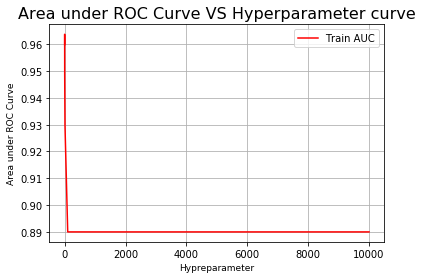

In [188]:
# determining best value of alpha

plt.plot(alpha , auc_score , label = "Train AUC" , color = 'r')
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.001
AUC =  92.48867960017031


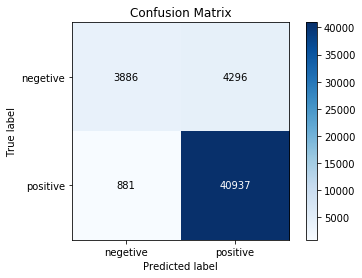

In [189]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1] , pos_label = "positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1] , pos_label = "positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

<Figure size 1440x720 with 0 Axes>

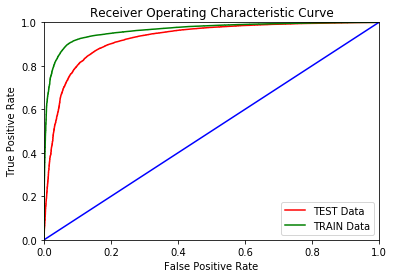

In [192]:
# method I: plt
plt.figure(figsize = (20 ,10))
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
## Positive Features

In [196]:
#Top 20 positive features

feature_name = count_vect.get_feature_names()
w = model.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Positive feature top 20 :
-------
great	-->	0.726402
best	-->	0.550854
love	-->	0.538433
delici	-->	0.492200
perfect	-->	0.428480
good	-->	0.419633
excel	-->	0.374821
amaz	-->	0.325990
nice	-->	0.306731
favorit	-->	0.267623
wonder	-->	0.266709
yummi	-->	0.231074
hook	-->	0.225442
addict	-->	0.224985
litter	-->	0.218722
tasti	-->	0.213602
easi	-->	0.208932
happi	-->	0.203560
awesom	-->	0.202836


In [0]:
## Negetive Features

In [198]:
#Top 20 negative features
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = tf_idf_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

Negative feature top 20 :
-------
disappoint	 -->	-0.325233  
worst	 -->	-0.272925  
glutam	 -->	-0.263759  
unfortun	 -->	-0.196308  
tast	 -->	-0.186596  
terribl	 -->	-0.178509  
bland	 -->	-0.177803  
would	 -->	-0.175479  
thought	 -->	-0.164611  
stale	 -->	-0.152230  
hope	 -->	-0.152190  
bad	 -->	-0.152118  
return	 -->	-0.150574  
stick	 -->	-0.150090  
aw	 -->	-0.143465  
money	 -->	-0.140695  
horribl	 -->	-0.140249  
sound	 -->	-0.135526  
earth	 -->	-0.133003  
mayb	 -->	-0.130184  


In [0]:
## Linear-SVM in Tf-Idf

In [0]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(X_train_tfidf)
X_test = sc.transform(X_test_tfidf)

In [201]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4] #alpha range between 10^-4 to 10^4
auc_score=[] # storing the auc value for each alpha


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [01:15<00:00,  5.07s/it]


In [202]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.001.


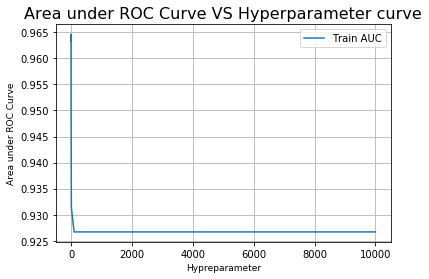

In [203]:
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.001
AUC =  93.36985891734011


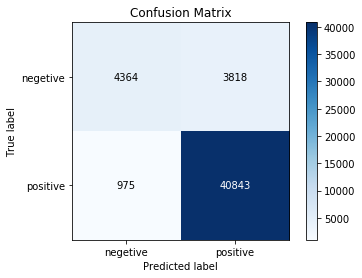

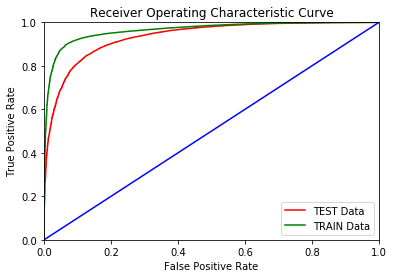

In [204]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
## Linear-SVM in 

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(sent_vectors_train)
X_test = sc.transform(sent_vectors_test)

In [208]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4] #alpha range between 10^-4 to 10^4
auc_score=[] # storing the auc value for each alpha


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [00:45<00:00,  4.38s/it]



The optimal value of alpha is 0.000.


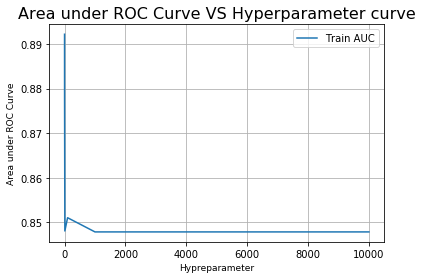

In [209]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.0001
AUC =  88.78594265598015


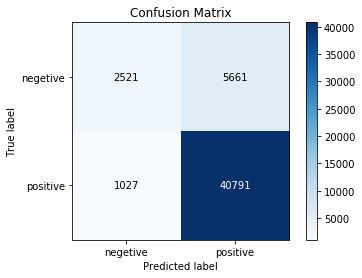

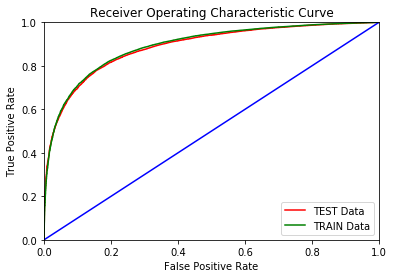

In [210]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
## Linear-SVM in Tf-Idf W2V

In [0]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(tfidf_sent_vectors_train)
X_test = sc.transform(tfidf_sent_vectors_test)

In [213]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4] 
auc_score=[]


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [00:52<00:00,  4.76s/it]



The optimal value of alpha is 0.001.


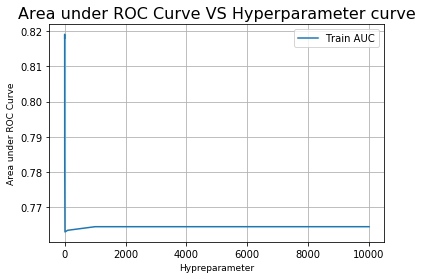

In [214]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.001
AUC =  80.90423457826157


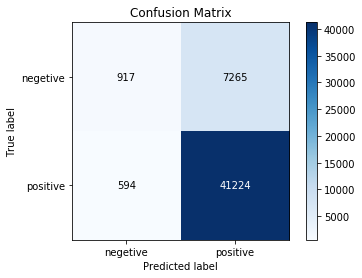

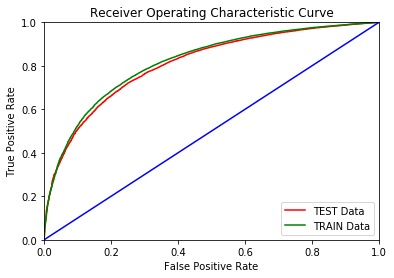

In [215]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive") #test data
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive") #train data

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
## RBF-SVM in BOW

In [0]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(X_train_BOW1)
X_test = sc.transform(X_test_BOW1)

In [0]:
all_C = [2**-1, 2**1, 2**3, 2**5, 2**7, 2**9]
all_Gammas = [2**-5, 2**-3, 2**-1, 2**1, 2**3, 2**5]

auc_scores = []

for i in tqdm(range(0,len(all_C))):
    model = svm.SVC(C = all_C[i], gamma=all_Gammas[i], kernel='rbf', probability=True, class_weight='balanced')
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test1, model.predict_proba(X_test)[:,1],pos_label="positive")
    auc = metrics.auc(fpr, tpr)
    auc_scores.append(auc*100)

  0%|          | 0/6 [00:00<?, ?it/s]

In [97]:
optimal_C = all_C[auc_scores.index(max(auc_scores))]
optimal_Gamma = all_Gammas[auc_scores.index(max(auc_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)
print('\nThe optimal value of Gamma is %.3f.' % optimal_Gamma)

# plot AUC vs C
plt.plot(all_C, auc_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

100%|██████████| 5/5 [01:11<00:00, 14.09s/it]



The optimal value of C is 0.000.


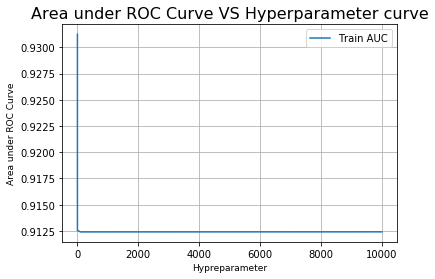

In [98]:
optimal_C = 0.500
optimal_Gamma = 0.031

***Test Data Report***
Best C =  0.0001
AUC =  93.66731573335812


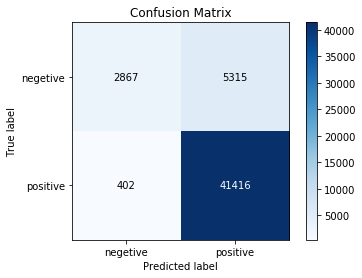

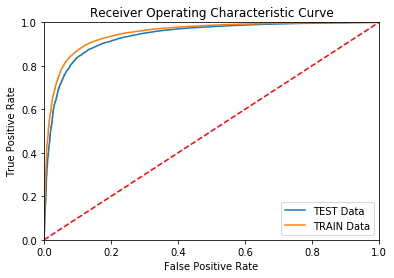

In [100]:
lr = svm.SVC(C = optimal_C, gamma=optimal_Gamma, kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
lr.fit(X_train,y_train1)
pred = lr.predict(X_test)



print("***Test Data Report***")
fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test1, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive") #test data
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train1, lr.predict_proba(X_train)[:,1],pos_label="positive") #train data

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
# RBF-SVM on TF-IDF

In [0]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(X_train_tfidf)
X_test = sc.transform(X_test_tfidf)

In [104]:
all_C = [2**-1, 2**1, 2**3, 2**5, 2**7, 2**9]
all_Gammas = [2**-5, 2**-3, 2**-1, 2**1, 2**3, 2**5]
#param_grid = {'C': all_C, 'gamma' : all_Gammas}
auc_scores = []
# range of C and Gamas
# https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters


for i in tqdm(range(0,len(all_C))):
    model = svm.SVC(C = all_C[i], gamma=all_Gammas[i], kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
    model.fit(X_train,y_train1)
    pred = model.predict(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test1, model.predict_proba(X_test)[:,1],pos_label="positive")
    auc = metrics.auc(fpr, tpr)
    auc_scores.append(auc*100)

Positive feature top 20 :
-------
great	-->	0.172712
love	-->	0.127362
best	-->	0.123505
delici	-->	0.101504
good	-->	0.085574
perfect	-->	0.084130
excel	-->	0.081663
favorit	-->	0.071779
nice	-->	0.069402
wonder	-->	0.068849
easi	-->	0.062981
find	-->	0.060398
amaz	-->	0.058427
alway	-->	0.057432
tasti	-->	0.056317
thank	-->	0.055925
happi	-->	0.052258
addict	-->	0.050018
keep	-->	0.049245


In [0]:
optimal_C = all_C[auc_scores.index(max(auc_scores))]
optimal_Gamma = all_Gammas[auc_scores.index(max(auc_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)
print('\nThe optimal value of Gamma is %.3f.' % optimal_Gamma)

In [0]:
# plot AUC vs C
plt.plot(all_C, auc_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

In [0]:
lr = svm.SVC(C = optimal_C, gamma=optimal_Gamma, kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
lr.fit(X_train,y_train1)
pred = lr.predict(X_test)



print("***Test Data Report***")
fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test1, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive") #test data
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train1, lr.predict_proba(X_train)[:,1],pos_label="positive") #train data

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()